Start by exploring the dataset, visualising the meshes, describing the data structure

In [ ]:
import open3d as o3d

import pyvista
pyvista.start_xvfb()
import numpy as np
from os.path import join
def pyvistarise(verts, triangles):
    return pyvista.PolyData(verts, np.insert(triangles, 0, 3, axis=1), deep=True, n_faces=len(triangles))

In [ ]:
mesh = o3d.io.read_triangle_mesh("data/meshes/camel.obj")
vertices = np.asarray(mesh.vertices)
vertices = vertices[:, [0,2,1]]
mesh.vertices = o3d.utility.Vector3dVector(vertices)
o3d.visualization.draw_plotly([mesh])

In [ ]:
# verts = np.asarray(mesh.vertices)
# triangles = np.asarray(mesh.triangles)
# pyv_mesh = pyvistarise(verts, triangles)
# pyvista.global_theme.background = 'white'
# plotter = pyvista.Plotter()
# plotter.add_mesh(pyv_mesh)
# plotter.show(jupyter_backend="static")

Introduce supervised and unsupervised learning, why unsupervised learning is most popular in this case. We need some metric to drive the learning process - encourage the model to make reasonable correspondence predictions.

Talk about geodesic paths and distance - how these can be used in the learning process

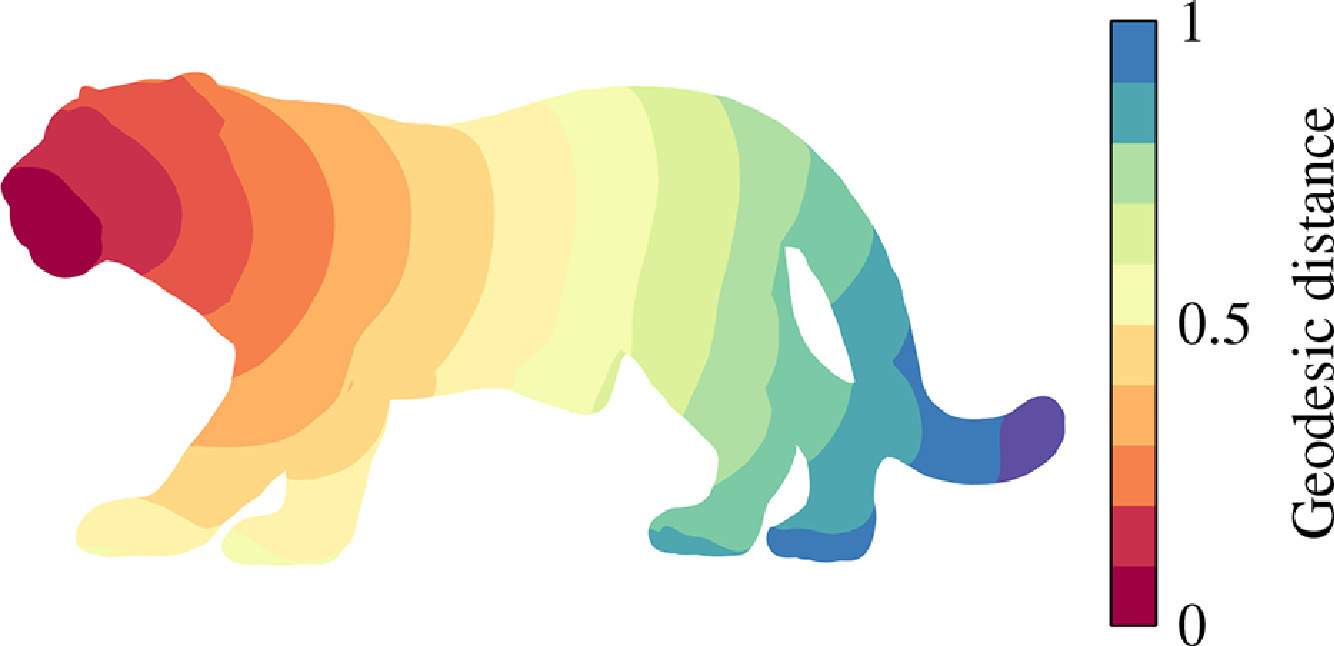

Then introduce registration loss, chamfer matching - overlap of the shapes

Its possible to attain perfect registration by deforming a shape wildly (present example) - need a way of regularising the allowed deformations - distortion metric

Preprocessing:

Start by computing the geodesic matrices for each shape

In [ ]:
import pygeodesic.geodesic as geodesic
from neuromorph_adapted.utils.utils import getFiles
from os.path import join
from tqdm import tqdm

data_folder = "data/meshes"
output_folder = "data/geodesic_distances"

fnames = getFiles(data_folder)

def compute_geodesic_distances(vertices, triangles):
    # compute geodesic distances between all pairs of vertices
    n_vertices = vertices.shape[0]
    geo_alg = geodesic.PyGeodesicAlgorithmExact(vertices, triangles)
    D = np.zeros((n_vertices, n_vertices), dtype=np.float16)
    for source_index in tqdm(range(n_vertices)):
        D[source_index], _ = geo_alg.geodesicDistances(np.array([source_index]))
    try:
        assert (D - D.T < 1e-4).all()
    except AssertionError: 
        print(f"Assertion error - max value: {np.abs(D - D.T).max()}")
        # If nan -> It's likely the mesh is not a single connected component -> run some connected component analysis
        return None
    return D

fname = fnames[0]
mesh = o3d.io.read_triangle_mesh(join(data_folder, fname))
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
D = compute_geodesic_distances(vertices, triangles)
if D is not None:
    print(f"Computed geodesic distances for {fname}")
    np.save(join(output_folder, fname.replace(".obj", ".npy")), D)
else:
    print(f"Failed to compute geodesic distances for {fname}")

Calculating full matrices takes too long! So calculate ahead of time and share.

As an example get the students to calculate the geodesic distance from a single point and visualise.

In [ ]:
import pygeodesic.geodesic as geodesic
from os.path import join
data_folder = "data/meshes"

fname = "camel.obj"
mesh = o3d.io.read_triangle_mesh(join(data_folder, fname))
vertices = np.asarray(mesh.vertices)[:, [0,2,1]] # just reordering x, y, z for visualisation
triangles = np.asarray(mesh.triangles)
geo_alg = geodesic.PyGeodesicAlgorithmExact(vertices, triangles)
source_index = 4000
target_index = 1500
distances, _ = geo_alg.geodesicDistances(np.array([source_index]))
distance, path = geo_alg.geodesicDistance(source_index, target_index)

pyv_mesh = pyvistarise(vertices, triangles)
pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter()
plotter.store_image = True

sargs = dict(title_font_size=28, label_font_size=26, shadow=False, n_labels=5, italic=False, fmt="%.1f", font_family="arial", color='black', bold=False, title="Geodesic distance")
plotter.add_mesh(pyv_mesh, show_edges=False, scalars=distances, cmap="YlOrRd", scalar_bar_args=sargs)
plotter.add_lines(path, color='b', width=5)
plotter.show(window_size=[1600, 1000], jupyter_backend="static")

Need to create some evaluation steps and metrics

Need to include some description of the network architecture, what each bit does, how it works and some figures.

First try inferencing a randomly initialised network

In [ ]:
import open3d as o3d
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase
import pyvista
import pickle

# load the model and some mesh data
data_folder = "data/meshes"
source_mesh = o3d.io.read_triangle_mesh(join(data_folder, "bison.obj"))
target_mesh = o3d.io.read_triangle_mesh(join(data_folder, "cow.obj"))

# inference

class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.num_timesteps = 0
        self.hidden_dim = 64

def run_correpondence_inference(model, source_mesh, target_mesh):
    
    def convert_to_batch(mesh):
        verts = torch.tensor(np.asarray(mesh.vertices).astype(np.float32))
        shift = torch.mean(verts, dim=0)
        verts = verts - shift
        #verts = verts / torch.max(torch.abs(verts))
        triangles = torch.tensor(np.asarray(mesh.triangles))
        return {"verts": verts, "triangles": triangles, "shift": shift}
    source_data = convert_to_batch(source_mesh)
    target_data = convert_to_batch(target_mesh)

    with torch.no_grad():
        source_shape = batch_to_shape(source_data)
        target_shape = batch_to_shape(target_data)

        point_pred = model.get_pred(source_shape, target_shape)
        point_pred = point_pred.cpu().numpy()

        corr_out = model.match(source_shape, target_shape)
        assignment = corr_out.argmax(dim=1).cpu().numpy()
        assignmentinv = corr_out.argmax(dim=0).cpu().numpy()

        source_verts = source_shape.verts.cpu().numpy()
        target_verts = target_shape.verts.cpu().numpy()
        triangles_x = source_shape.triangles.cpu().numpy()
        triangles_y = target_shape.triangles.cpu().numpy()

        result = {}
        result["assignment"] = assignment
        result["assignmentinv"] = assignmentinv
        result["X"] = {"verts": source_verts, "triangles": triangles_x, "shift": source_data["shift"]}
        result["Y"] = {"verts": target_verts, "triangles": triangles_y, "shift": target_data["shift"]}
        result["interpolation_verts"] = point_pred
        result["raw_correspondence_predictions"] = corr_out.cpu().numpy()
        
        return result


interpolation_energy = ArapInterpolationEnergy()
correspondence_model = InterpolationModGeoEC(interpolation_energy, NetworkParameters()).to(device)

result = run_correpondence_inference(correspondence_model, source_mesh, target_mesh)
with open("temp/random_init_correspondence_result.pkl", "wb") as f:
    pickle.dump(result, f)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(window_size=[1600, 1000], jupyter_backend="static")


Now try training the network on a small subset of data for a few epochs

In [ ]:
# training code
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase, k_fold_split_train_val_test, getFiles

class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.lr = 1e-4
        self.num_it = 1
        self.batch_size = 16
        self.num_timesteps = 0
        self.hidden_dim = 128
        self.lambd = 1
        self.lambd_geo = 100
        self.lambd_arap = 1

        self.log_freq = 1
        self.val_freq = 1

        self.log = True

def create_correspondence_model(dataset, dataset_val=None, time_stamp=None, description="", param=NetworkParameters(), folder_weights_load=None):
    if time_stamp is None:
        time_stamp = get_timestr()

    interpol_energy = ArapInterpolationEnergy()

    interpol_module = InterpolationModGeoEC(interpol_energy, param).to(device)

    preproc_mods = []
    preproc_mods.append(PreprocessRotateSame(dataset.axis))
    
    settings_module = timestep_settings(increase_thresh=3)
    
    train_loader = torch.utils.data.DataLoader(dataset, shuffle=True)
    if dataset_val is not None:
        val_loader = torch.utils.data.DataLoader(dataset_val, shuffle=False)
    else:
        val_loader = None

    interpol = InterpolNet(interpol_module, train_loader, val_loader=val_loader, time_stamp=time_stamp, description=description, preproc_mods=preproc_mods, settings_module=settings_module)

    if folder_weights_load is not None:
        interpol.load_self(save_path(folder_str=folder_weights_load))

    return interpol

data_folder = "/home/ed/postdoc/correspondence_workshop/data/"

# determine which meshes to use
# all_fnames = getFiles(join(data_folder, "meshes"))
# train_inds, val_inds, _ = k_fold_split_train_val_test(dataset_size=len(all_fnames), fold_num=1, seed=1004)
# train_fnames = [all_fnames[i].replace('.obj','') for i in train_inds]
# val_fnames = [all_fnames[i].replace('.obj','') for i in val_inds]

train_fnames = ["bear", "camel", "dog", "elephant", "giraffe", "hippo", "leopard", "pig", "rhino"] 
#val_fnames = ["bison", "cow"]

dataset_train = general_dataset(data_folder, fnames=train_fnames, load_dist_mat=True)
#dataset_val = general_dataset(data_folder, fnames=val_fnames, load_dist_mat=True)

correspondence_model = create_correspondence_model(dataset_train, dataset_val=None, description=f"test1")
correspondence_model.train()


Retry inference with a model that has been trained for a single epoch

In [ ]:
# load the model and some mesh data
data_folder = "data/meshes"
source_mesh = o3d.io.read_triangle_mesh(join(data_folder, "bison.obj"))
target_mesh = o3d.io.read_triangle_mesh(join(data_folder, "cow.obj"))

# inference
result = run_correpondence_inference(correspondence_model.interp_module, source_mesh, target_mesh)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(window_size=[1600, 1000], jupyter_backend="static")

Load model trained for many epochs

In [ ]:
import open3d as o3d
from neuromorph_adapted.model.interpolation_net import *
from neuromorph_adapted.utils.arap import ArapInterpolationEnergy
from neuromorph_adapted.data.data import *
from neuromorph_adapted.utils.utils import ParametersBase
import pyvista

class NetworkParameters(ParametersBase):
    def __init__(self):
        super().__init__()
        self.lr = 1e-4
        self.num_it = 1
        self.batch_size = 16
        self.num_timesteps = 0
        self.hidden_dim = 128
        self.lambd = 1
        self.lambd_geo = 100
        self.lambd_arap = 1

        self.log_freq = 1
        self.val_freq = 1

        self.log = True

interpol_energy = ArapInterpolationEnergy()
correspondence_model = InterpolationModGeoEC(interpol_energy, param=NetworkParameters()).to(device)
correspondence_model.load_self("models/2024_06_11__11_20_29_offline_train_500epochs/", num_epoch=229)

# load the model and some mesh data
data_folder = "data/meshes"
source_mesh = o3d.io.read_triangle_mesh(join(data_folder, "bison.obj"))
target_mesh = o3d.io.read_triangle_mesh(join(data_folder, "cow.obj"))

# inference
result = run_correpondence_inference(correspondence_model, source_mesh, target_mesh)
with open("temp/trained_correspondence_result.pkl", "wb") as f:
    pickle.dump(result, f)

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)
plotter.show(window_size=[1600, 1000], jupyter_backend="static")

# Numerical evaluation

## we're going to use these landmarks and the geodesic dsistances

In [ ]:
import scipy.io as sio

# display outputs (visualise)
source_verts = result["X"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
target_verts = result["Y"]["verts"][:, [0,2,1]] # just reordering x, y, z for visualisation
triangles_x = result["X"]["triangles"]
triangles_y = result["Y"]["triangles"]

# offset
target_verts = target_verts + np.array([1,0,0])

pyvista.global_theme.background = 'white'
plotter = pyvista.Plotter(notebook=True)

# Forward assignment
# set colours on target mesh corresponding with xyz position
target_colours = target_verts - np.min(target_verts, axis=0)
target_colours = target_colours / np.max(target_colours, axis=0)
target_colours = np.concatenate([target_colours, np.ones((len(target_colours), 1))], axis=1)
# set colours on source mesh according to the predicted correspondence assignment
assignment = result["assignment"]
source_colours = target_colours[assignment]

# add points
plotter.add_points(target_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=target_colours, rgb=True)
plotter.add_points(source_verts, opacity=1., point_size=10, render_points_as_spheres=True, scalars=source_colours, rgb=True)



bison_landmark_indices = sio.loadmat("data/ground_truth_landmarks/bison.mat")
cow_landmark_indices = sio.loadmat("data/ground_truth_landmarks/cow.mat")
source_landmark_indices = {k: v for k, v in zip(list(bison_landmark_indices["points"].flatten()), list(bison_landmark_indices["centroids"]))}
target_landmark_indices = {k: v for k, v in zip(list(cow_landmark_indices["points"].flatten()), list(cow_landmark_indices["centroids"]))}
correspondence_lookup = {k: v for k, v in enumerate(assignment)}
common_landmarks = list(set(source_landmark_indices.keys()) & set(target_landmark_indices.keys()))

s_l = (np.array(list(source_landmark_indices.values())) - result["X"]["shift"].numpy())[:, [0,2,1]]
t_l = (np.array(list(target_landmark_indices.values())) - result["Y"]["shift"].numpy())[:, [0,2,1]] + np.array([1,0,0])
plotter.add_points(s_l, opacity=1., point_size=20, render_points_as_spheres=True, color='r')
plotter.add_points(t_l, opacity=1., point_size=20, render_points_as_spheres=True, color='r')

plotter.show(window_size=[1600, 1000], jupyter_backend="static")


In [ ]:
import scipy.io as sio
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# evaluate before and after training
# Geodesic distance normalised by the square root area of the mesh
def get_geodesic_error(geodesic_dists_x, geodesic_dists_y, assignment, area_y, n_sample=10000):
    geodesic_dists_x_prime = geodesic_dists_y[assignment]
    geodesic_dists_x_prime = geodesic_dists_x_prime[:, assignment]
    error = np.abs(geodesic_dists_x - geodesic_dists_x_prime)

    # errors normalised by the square root area of the mesh
    geodesic_error = error / np.sqrt(area_y)
    # sample n_sample points
    geodesic_error = geodesic_error.reshape(-1)
    geodesic_error_sample = np.random.choice(geodesic_error, n_sample, replace=False)
    return geodesic_error_sample


# landmark based error
def get_nearest_vertices_to_landmarks(landmarks, vertices):
    kdtree = KDTree(vertices)
    nearest_vertices = {}
    for landmark_index, landmark in landmarks.items():
        nearest_vertices[landmark_index] = kdtree.query(landmark)[1]
    return nearest_vertices

def landmark_errors(source_landmark_vertices, target_landmark_vertices, assignment, target_geodesic_dists, target_area):
    correspondence_lookup = {k: v for k, v in enumerate(assignment)}
    common_landmark_indices = list(set(source_landmark_vertices.keys()) & set(target_landmark_vertices.keys()))
    errors = []
    for landmark_index in common_landmark_indices:
        source_landmark = source_landmark_vertices[landmark_index]
        target_landmark = target_landmark_vertices[landmark_index]
        target_landmark_prime = correspondence_lookup[source_landmark]
        error = target_geodesic_dists[target_landmark, target_landmark_prime] / np.sqrt(target_area)
        errors.append(error)
    return errors

# load evaluation datasets
bison_landmarks = sio.loadmat("data/ground_truth_landmarks/bison.mat")
cow_landmarks = sio.loadmat("data/ground_truth_landmarks/cow.mat")
bison_vertices = np.asarray(o3d.io.read_triangle_mesh(join(data_folder, "bison.obj")).vertices)
cow_vertices = np.asarray(o3d.io.read_triangle_mesh(join(data_folder, "cow.obj")).vertices)
cow_geodesic_dists = np.load("data/geodesic_distances/cow.npy")
bison_geodesic_dists = np.load("data/geodesic_distances/bison.npy")
cow_area = target_mesh.get_surface_area()

bison_landmarks = {k: v for k, v in zip(list(bison_landmarks["points"].flatten()), list(bison_landmarks["centroids"]))}
cow_landmarks = {k: v for k, v in zip(list(cow_landmarks["points"].flatten()), list(cow_landmarks["centroids"]))}
bison_landmark_vertices = get_nearest_vertices_to_landmarks(bison_landmarks, bison_vertices)
cow_landmark_vertices = get_nearest_vertices_to_landmarks(cow_landmarks, cow_vertices)

# load the resulting correspondences from the randomly initialised model
with open("temp/random_init_correspondence_result.pkl", "rb") as f:
    result = pickle.load(f)
# compute the errors
random_init_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, result["assignment"], cow_geodesic_dists, cow_area)
random_init_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, result["assignment"], cow_area)

# load the resulting correspondences from the trained model
with open("temp/trained_correspondence_result.pkl", "rb") as f:
    result = pickle.load(f)
# compute the errors
trained_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, result["assignment"], cow_geodesic_dists, cow_area)
trained_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, result["assignment"], cow_area)

# for fun - generate error metrics from randomly assigned correspondences
random_assignment = np.random.choice(len(cow_vertices), size=len(bison_vertices))
no_model_errors = landmark_errors(bison_landmark_vertices, cow_landmark_vertices, random_assignment, cow_geodesic_dists, cow_area)
no_model_geodesic_error = get_geodesic_error(bison_geodesic_dists, cow_geodesic_dists, random_assignment, cow_area)

## Quick plotting of the errors
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(16,8))

# violin plots for the ground truth landmark errors
violinplots = ax0.violinplot([no_model_errors, random_init_errors, trained_errors], positions=[1, 1.6, 2.2], showmeans=True,)
ax0.set_xticks([1, 1.6, 2.2])
ax0.set_xticklabels(["No model", "Random\ninitialisation", "Trained model"])
ax0.set_ylabel("Normalised landmark error")
ax0.set_ylim(0)
colours = ['red', 'blue', 'green']
for i, plot_body in enumerate(violinplots['bodies']):
    plot_body.set_facecolor(colours[i])
    plot_body.set_edgecolor('black')
    plot_body.set_alpha(1)
for line in ['cbars','cmins','cmaxes']:
    violinplots[line].set_color('black')
    violinplots[line].set_linewidth(2)
violinplots['cmeans'].set_linestyle('--')
violinplots['cmeans'].set_color('white')
violinplots['cmeans'].set_linewidth(2)

# cumulative distribution of the geodesic errors
ax1.plot(np.sort(no_model_geodesic_error), np.linspace(0, 100, len(no_model_geodesic_error)), c=colours[0], label="No model")
ax1.plot(np.sort(random_init_geodesic_error), np.linspace(0, 100, len(random_init_geodesic_error)), c=colours[1], label="Random init")
ax1.plot(np.sort(trained_geodesic_error), np.linspace(0, 100, len(trained_geodesic_error)), c=colours[2], label="Trained")

ax1.set_xlabel("Geodesic error")
ax1.set_ylabel(r"% of matches")
ax1.set_ylim(0, 100)
ax1.set_xlim(0)
ax1.legend(loc="lower right")
plt.show()

How about training on a large separate dataset

Application to radiotherapy